# Simple Improved Reference Subtraction (SIRS)<br>James Webb Space Telescope NIRCam Example

Bernard.J.Rauscher@nasa.gov<br>
3 December 2021

This notebook shows how to compute the SIRS frequency dependent weights for a JWST NIRCam detector. This is the SIRS "front-end".

In [3]:
# Standard imports
using Revise        # Handy for interactive work
using Glob          # Filename globbing
using FITSIO        # Julia's standard FITS package
using Jacobi        # Legendre polynomials defined here
using LinearAlgebra # Moore-Penrose inverse is here
using OMEinsum      # Tensor operations
using StatsBase     # Robuts statistics
using Plots         # Plotting
using JLD           # Saving results
using Dates         # Helpful to reporting status

# Simple Improved Reference Subtraction (SIRS)
using SIRS

In [4]:
# The data are here
ddir = ENV["HOME"]*"/data1/JWST/NIRCam/" # gs66-racy.ndc.nasa.gov
# ddir = "/gpfsm/ccds01/nobackup/temp/brausche/NIRCam/"

"/local/data/home/brausche/data1/JWST/NIRCam/"

In [5]:
# Get a list of the input files
files = glob("*.fits", ddir)

# Exclude the last so that it can be used to check the result
files = files[1:end-1]
;

In [6]:
# Instantiate a SIRSCore. From looking at the FITS headers, I know that
# the files have 108 frames sampled up-the-ramp. For JWST:
# - 2048x2048 pixels
# - 4 outputs
# - 12 pixels overhead at end of each line
# - 10 µs pixel dwell time
sc = SIRSCore("h2rg", 4, 12, 10.e-6, 108);

In [7]:
# Coadd in preparation for solving for α and β.
count = 1 # A counter
@time for file in files
    
    # Show some status
    println(Dates.format(now(), "HH:MM:SS"), " processing file #", count, " of ", length(files))
    flush(stdout)
    count += 1
   
    # JWST NIRCam data
    f = FITS(file, "r")
    D = Float64.(read(f[1]))
    close(f)
        
    # Coadd
    coadd!(sc, D)

end

14:03:55 processing file #1 of 10
14:04:53 processing file #2 of 10
14:05:41 processing file #3 of 10
14:06:25 processing file #4 of 10
14:07:10 processing file #5 of 10
14:07:55 processing file #6 of 10
14:08:38 processing file #7 of 10
14:09:21 processing file #8 of 10
14:10:07 processing file #9 of 10
14:10:48 processing file #10 of 10
459.316724 seconds (335.29 M allocations: 731.043 GiB, 4.80% gc time, 0.21% compilation time)


In [8]:
# Solve for frequency dependent weights
solve!(sc);

In [9]:
# Save results
SIRS.save(sc, ENV["HOME"]*"/tmp/20151217_nircam_sirs.jld")
export_to_sirspy(sc, ENV["HOME"]*"/tmp/20151217_nircam_sirs.h5");

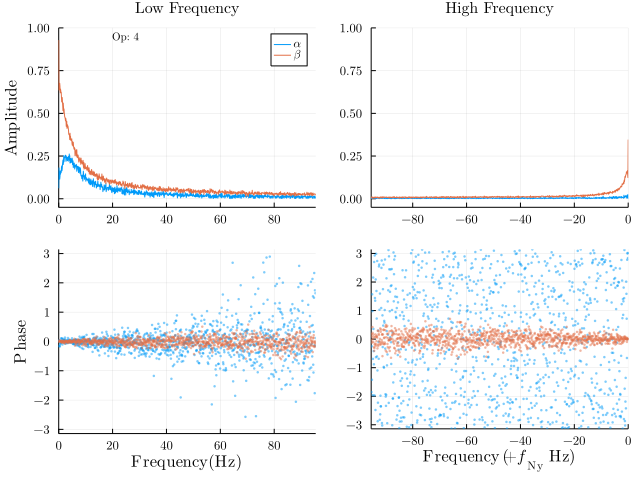

In [10]:
# Make a plot to show that they are reasonable
op1 = wplot(sc, 4, nice=false) # The second parameter is the output number selected
                               # from {1,2,3,4}.